# Financial Independence - Monte Carlo Simulation
## Theoretical model

The theory behind the following equations can be found in [this notebook](https://github.com/OlegZero13/Data-Science-Algorithm-Gallery/blob/master/Personal_Financial_Simulator_with_ODE.ipynb) and [this article](https://zerowithdot.com/financial-independence-ode-python/).
It is based on numerically solving a system of coupled _ordinary differential equations_:

$$
\left\{\begin{matrix}
\frac{d}{dt} x_1(t) &= \Delta (1 - \beta) - x_1\ln(1 + \xi) \\
\frac{d}{dt} x_2(t) &= \beta \Delta + x_2\ln(1 + R) - x_2\ln(1 + \xi)
\end{matrix}\right.
$$

we turn into

$$
\frac{d}{dt}x = \Delta(t) + x\ln\left(\frac{1 + \beta R}{1 + \xi}\right)
$$

where
* $x$ is the amount of money,
* $\xi$ is the inflation rate.
* $\Delta = \Delta(t)$ is the balance amount that is left each year.
* $R$ is the interest rate upon investment
* $\beta$ is the fraction of the balance that is invested. Note that $(1 + \beta R)$ can be considered an _effective_ rate of interest.

The goal is to see how far you can make it.

### Basic model

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Life:
    def __init__(self):
        self.t0 = 25  # starting age
        self.beta = 0.5  # investment fraction
        self.r = 0.05  # interest rate
        self.xi = 0.028  # inflation rate
        self.x0 = 0  # initial amount
        self.balance_fn = lambda x: 1000  # balance function
    
    def live(self, x, t):
        rate = self.balance_fn(t - self.t0) \
             + np.log(1 + self.beta * self.r) * x \
             - np.log(1 + self.xi) * x
        return rate

def run(x, t, you):
    result = you.live(x, t)
    return result

### Simulation

In [3]:
def simulate(you):
    t0 = np.linspace(0, you.t0 - 1, num=you.t0)
    t1 = np.linspace(you.t0, 120, num=(120 - you.t0 + 1))
    
    x_t0 = np.zeros(len(t0)).reshape(-1, 1)
    x_t1 = odeint(run, [you.x0], t1, args=(you,))
    
    df0 = pd.DataFrame({'time': t0, 'x': x_t0[:, 0]})
    df1 = pd.DataFrame({'time': t1, 'x': x_t1[:, 0]})
    return pd.concat([df0, df1]).set_index('time')

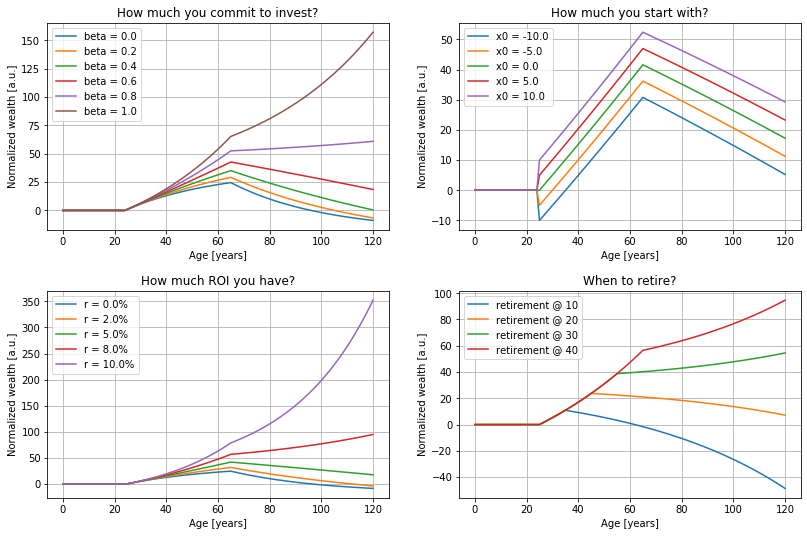

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.tight_layout(pad=4)

for b in np.linspace(0, 1, num=6):
    you = Life()
    you.beta = b
    you.x0 = 1.0
    you.balance_fn = lambda x: 1.0 if x < 40 else -0.5

    df = simulate(you)
    axs[0, 0].plot(df, label=f'beta = {b:0.1f}')
axs[0, 0].set_xlabel('Age [years]')
axs[0, 0].set_ylabel('Normalized wealth [a.u.]')
axs[0, 0].set_title('How much you commit to invest?')
axs[0, 0].grid()
axs[0, 0].legend()

for x0 in np.linspace(-10, 10, num=5):
    you = Life()
    you.beta = 0.6
    you.x0 = x0
    you.balance_fn = lambda x: 1.0 if x < 40 else -0.5

    df = simulate(you)
    axs[0, 1].plot(df, label=f'x0 = {x0}')
axs[0, 1].set_xlabel('Age [years]')
axs[0, 1].set_ylabel('Normalized wealth [a.u.]')
axs[0, 1].set_title('How much you start with?')
axs[0, 1].grid()
axs[0, 1].legend()

for r in np.linspace(-0.0, 0.1, num=5):
    you = Life()
    you.beta = 0.6
    you.x0 = 0.0
    you.r = r
    you.xi = 0.028
    you.balance_fn = lambda x: 1.0 if x < 40 else -0.5

    df = simulate(you)
    axs[1, 0].plot(df, label=f'r = {round(r*100)}%')
axs[1, 0].set_xlabel('Age [years]')
axs[1, 0].set_ylabel('Normalized wealth [a.u.]')
axs[1, 0].set_title('How much ROI you have?')
axs[1, 0].grid()
axs[1, 0].legend()

for y in np.linspace(10, 40, num=4):
    you = Life()
    you.beta = 0.75
    you.r = 0.06
    you.xi = 0.028
    you.balance_fn = lambda x: 1.0 if x < y else -0.5

    df = simulate(you)
    axs[1, 1].plot(df, label=f'retirement @ {int(y)}')
axs[1, 1].set_xlabel('Age [years]')
axs[1, 1].set_ylabel('Normalized wealth [a.u.]')
axs[1, 1].set_title('When to retire?')
axs[1, 1].grid()
axs[1, 1].legend(loc='upper left')

plt.show()

## Deterministic future - different people
### Balance functions

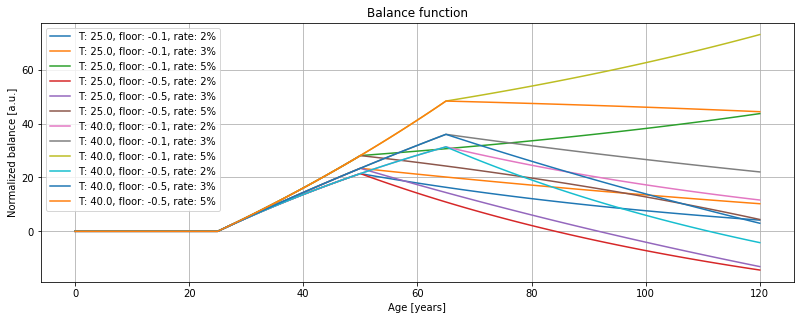

In [5]:
from itertools import product


FLOORS = [-0.1, -0.5]
DURATIONS = np.linspace(25, 40, num=2)
RATES = [0.02, 0.03, 0.05]


def rect(t, t0, duration=30, floor=-0.5):
    x = np.where(t - t0 <= duration, 1.0, floor)
    mask = np.where(t > t0, 1.0, 0.0)
    return x * mask


t = np.linspace(0, 120, num=121)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
fig.tight_layout(pad=4)

diags = []
for du, fl, r in product(DURATIONS, FLOORS, RATES):
    you = Life()
    you.beta = 0.75
    you.r = r
    you.balance_fn = lambda t: rect(t + 25, 25, du, fl)
    df = simulate(you)
    
    diags.append({**you.__dict__, 
        'passive': float(df[df.index > you.t0 + du].diff().sum()) > 0,
        'duration': du, 
        'floor': fl
    })
    
    ax.plot(df['x'], label=f'T: {du}, floor: {fl}, rate: {round(r*100)}%')

ax.set_xlabel('Age [years]')
ax.set_ylabel('Normalized balance [a.u.]')
ax.set_title('Balance function')
ax.grid()
ax.legend()
plt.show()

In [6]:
pd.DataFrame(diags).drop(columns='balance_fn')

,t0,beta,r,xi,x0,passive,duration,floor
0,25,0.75,0.02,0.028,0,False,25.0,-0.1
1,25,0.75,0.03,0.028,0,False,25.0,-0.1
2,25,0.75,0.05,0.028,0,True,25.0,-0.1
3,25,0.75,0.02,0.028,0,False,25.0,-0.5
4,25,0.75,0.03,0.028,0,False,25.0,-0.5
5,25,0.75,0.05,0.028,0,False,25.0,-0.5
6,25,0.75,0.02,0.028,0,False,40.0,-0.1
7,25,0.75,0.03,0.028,0,False,40.0,-0.1
8,25,0.75,0.05,0.028,0,True,40.0,-0.1
9,25,0.75,0.02,0.028,0,False,40.0,-0.5


## Adding random factor

As life is full of surprises, we will now add a few random contributions $
\delta$ to:
* $\Delta(t + dt) := \Delta(t) + \mathcal{N}(x|0,\sigma_\Delta^2)$ - balance, that will represent some personal situation, modeled through a random walk.
* $R := \mathcal{N}(t|\mu_R, \sigma_R^2)$ - interest rate, that will represent the uncertainty of the market,
* $\xi := \mathcal{N}(t|\mu_\xi, \sigma_\xi^2)$ - inflation rate, that will represent the uncertainty of the country.

Here, $\mathcal{N}(t|\mu, \sigma^2)$ is a normal distribution with $\mu$ mean and $\sigma^2$ variance.

In addition to that, we will randomize $\beta$.
Since it is a _commitment factor_, we assume $\beta = $const. and we get it from Beta distribution as $\beta \in [0, 1]$, namely:

$$
\beta = \frac{1}{\mathcal{B}(a, b)}x^{a - 1}(1 - x)^{b - 1}, \text{ where } \mathcal{B}(a, b) = \int_0^1 u^{a - 1}(1 - u)^{b - 1}du
$$

In [7]:
class RealLife:
    def __init__(self):
        self.t0 = 25  # starting age
        self.beta = np.random.beta(2, 5)
        self.mu_r = 0.05
        self.sigma_r = 0.25
        self.mu_xi = 0.028
        self.sigma_xi = 0.025
        self.x0 = 0  # initial amount
        self.balance_fn = lambda x: 1  # balance function
        self.sigma_delta = 2.0
        
        self._rs = []
        self._xis = []
        self._deltas = []

    def get_average_r(self):
        return np.array(self._rs).mean()
    
    def get_average_xi(self):
        return np.array(self._xis).mean()
    
    def get_average_delta(self):
        return np.array(self._deltas).mean()
        
    def live(self, x, t):
        delta = self.sigma_delta * np.random.randn()
        r = self.sigma_r * np.random.randn() + self.mu_r
        xi = self.sigma_xi * np.random.randn() + self.mu_xi
        
        self._rs.append(r)
        self._deltas.append(delta)
        self._xis.append(xi)
        
        rate = self.balance_fn(t - self.t0) \
             + np.log(1 + self.beta * r) * x \
             - np.log(1 + xi) * x
        return rate
    
    
def sdeint(func, x0, t):    
    x = np.zeros(t.size, dtype=float)
    x[0] = x0

    for i, dt in enumerate(t[1:]):
        x[i + 1] = x[i] + func(x[i], dt)

    return x

def simulate_with_random(you):
    t0 = np.linspace(0, you.t0 - 1, num=you.t0)
    t1 = np.linspace(you.t0, 120, num=(120 - you.t0 + 1))
    
    x_t0 = np.zeros(t0.size)
    x_t1 = sdeint(you.live, you.x0, t1)
    
    df0 = pd.DataFrame({'time': t0, 'x': x_t0})
    df1 = pd.DataFrame({'time': t1, 'x': x_t1})
    return pd.concat([df0, df1]).set_index('time')

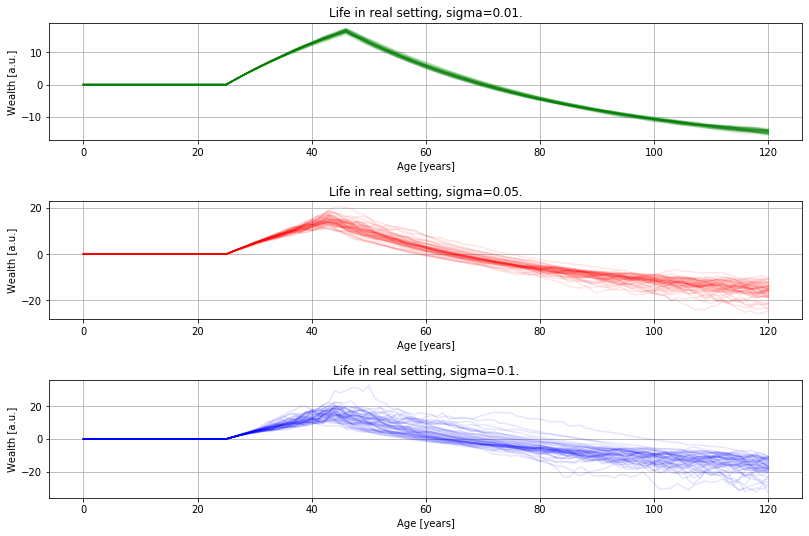

In [8]:
np.random.seed(42)

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout(pad=4)
 
j = 0
for c, s in zip(tuple('grb'), (0.01, 0.05, 0.1)):
    you = RealLife()
    you.mu_r = 0.01
    you.sigma_r = s
    you.sigma_xi = s
    duration = np.random.randint(15, 40)
    you.balance_fn = lambda t: rect(t + 25, 25, duration)
    t = np.linspace(0, 120, num=121)

    diags = []
    for i in range(50):
        ax[j].plot(t, sdeint(you.live, 0, t), alpha=0.1, color=c)
        diag = {
            'avg_delta': you.get_average_delta(),
            'avg_r': you.get_average_r(),
            'avg_xi': you.get_average_xi()
        }
        diags.append(diag)
    
    ax[j].set_xlabel("Age [years]")
    ax[j].set_ylabel("Wealth [a.u.]")
    ax[j].set_title(f"Life in real setting, sigma={s}.")
    ax[j].grid()
    j += 1

plt.show()

### Normal case
```
        self.t0 = 25  # starting age
        self.beta = np.random.beta(2, 5)
        self.mu_r = 0.05
        self.sigma_r = 0.5
        self.mu_xi = 0.028
        self.sigma_xi = 0.05
        self.x0 = 0  # initial amount
        self.balance_fn = lambda x: 1  # balance function
        self.sigma_delta = 2.0
```

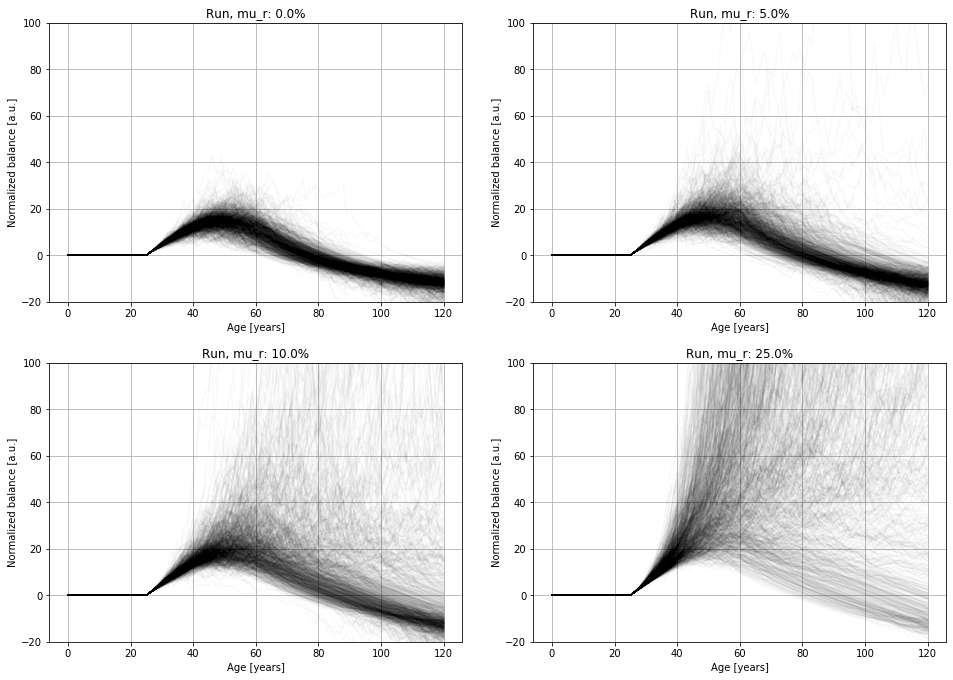

In [9]:
import warnings
warnings.simplefilter("ignore")

t = np.linspace(0, 120, num=121)
np.random.seed(42)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=4)

diags = []
for i, r in enumerate((0.0, 0.05, 0.10, 0.25)):
    for _ in range(1000):
        you = RealLife()
        you.mu_r = r
        you.balance_fn = lambda t: rect(t, you.x0, np.random.randint(15, 40))
        df = simulate_with_random(you)

        diags.append({
            'beta': you.beta,
            'avg_r': you.get_average_r(),
            'avg_delta': you.get_average_delta(),
            'avg_xi': you.get_average_xi(),
            'passive': float(df[df.index > you.t0 + du].diff().sum()) > 0
        })

        axs[i // 2, i % 2].plot(t, sdeint(you.live, 0, t), alpha=0.025, color='k')
    axs[i // 2, i % 2].set_xlabel('Age [years]')
    axs[i // 2, i % 2].set_ylabel('Normalized balance [a.u.]')
    axs[i // 2, i % 2].set_title(f'Run, mu_r: {you.mu_r * 100}%')
    axs[i // 2, i % 2].set_ylim((-20, 100))
    axs[i // 2, i % 2].grid()
plt.show()

In [10]:
dg = pd.DataFrame(diags)
dg['passive'] = dg['passive'].astype(int)
dg

,beta,avg_r,avg_delta,avg_xi,passive
0,0.353677,0.027808,0.255843,0.025158,0
1,0.128092,0.035025,0.306877,0.027297,0
2,0.295983,0.027151,0.046431,0.026601,0
3,0.200086,-0.010691,0.223547,0.032506,0
4,0.478920,-0.002326,0.098097,0.027891,0
...,...,...,...,...,...
3995,0.169046,0.244695,0.145974,0.026516,1
3996,0.071058,0.215935,0.180699,0.028840,0
3997,0.437137,0.282627,-0.292938,0.032478,1
3998,0.105269,0.211938,-0.041953,0.029368,0


### Case - low investment tendency
Beta (1, 10)

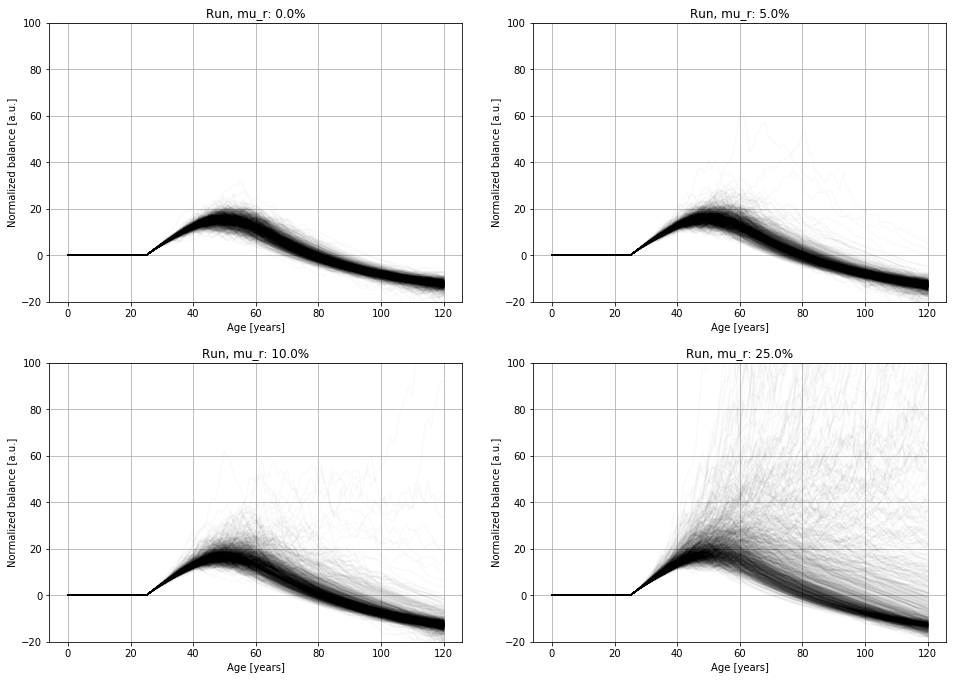

In [11]:
import warnings
warnings.simplefilter("ignore")

t = np.linspace(0, 120, num=121)
np.random.seed(42)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=4)

diags = []
for i, r in enumerate((0.0, 0.05, 0.10, 0.25)):
    for _ in range(1000):
        you = RealLife()
        you.mu_r = r
        you.beta = np.random.beta(1, 10)
        you.balance_fn = lambda t: rect(t, you.x0, np.random.randint(15, 40))
        df = simulate_with_random(you)

        diags.append({
            'beta': you.beta,
            'avg_r': you.get_average_r(),
            'avg_delta': you.get_average_delta(),
            'avg_xi': you.get_average_xi(),
            'passive': float(df[df.index > you.t0 + du].diff().sum()) > 0
        })

        axs[i // 2, i % 2].plot(t, sdeint(you.live, 0, t), alpha=0.025, color='black')
    axs[i // 2, i % 2].set_xlabel('Age [years]')
    axs[i // 2, i % 2].set_ylabel('Normalized balance [a.u.]')
    axs[i // 2, i % 2].set_title(f'Run, mu_r: {you.mu_r * 100}%')
    axs[i // 2, i % 2].set_ylim((-20, 100))
    axs[i // 2, i % 2].grid()
plt.show()

In [12]:
dg1 = pd.DataFrame(diags)
dg1['passive'] = dg1['passive'].astype(int)
dg1

,beta,avg_r,avg_delta,avg_xi,passive
0,0.015808,0.027832,0.265704,0.025368,0
1,0.026718,0.032623,0.095758,0.028435,0
2,0.142675,0.013966,0.071891,0.026849,0
3,0.127124,-0.024258,0.291324,0.035552,0
4,0.077364,0.004386,0.139839,0.028611,0
...,...,...,...,...,...
3995,0.045273,0.238073,0.180607,0.023496,0
3996,0.085759,0.238422,0.079030,0.029953,0
3997,0.064833,0.290749,0.026664,0.027264,0
3998,0.018445,0.271242,0.007638,0.030215,0


### Case - investment behavour encouraged

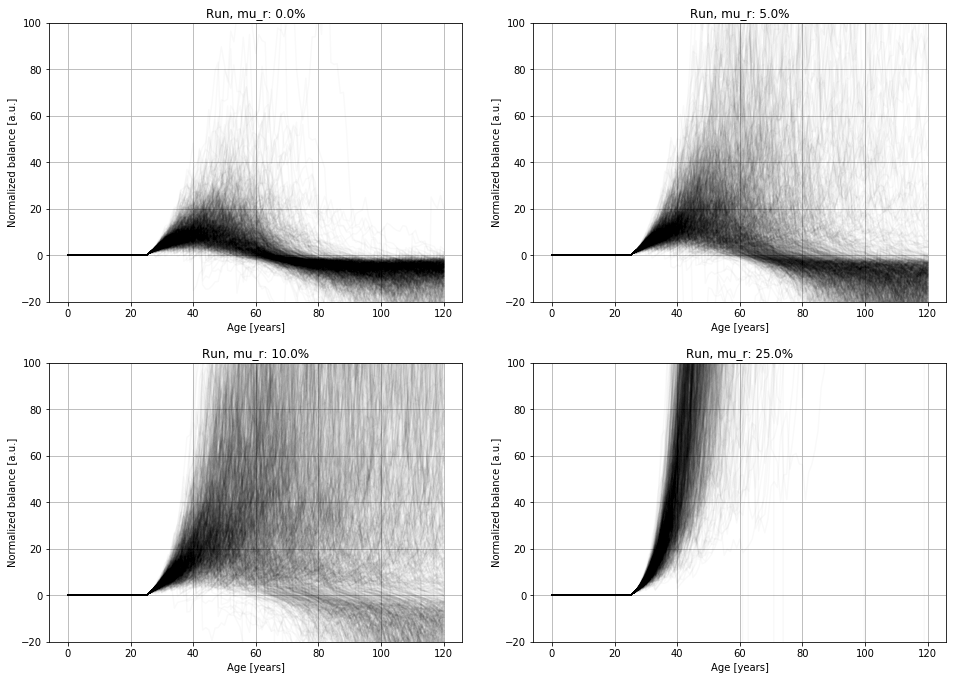

In [13]:
import warnings
warnings.simplefilter("ignore")

t = np.linspace(0, 120, num=121)
np.random.seed(42)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=4)

diags = []
for i, r in enumerate((0.0, 0.05, 0.10, 0.25)):
    for _ in range(1000):
        you = RealLife()
        you.mu_r = r
        you.beta = np.random.beta(10, 1)
        you.balance_fn = lambda t: rect(t, you.x0, np.random.randint(15, 40))
        df = simulate_with_random(you)

        diags.append({
            'beta': you.beta,
            'avg_r': you.get_average_r(),
            'avg_delta': you.get_average_delta(),
            'avg_xi': you.get_average_xi(),
            'passive': float(df[df.index > you.t0 + du].diff().sum()) > 0
        })

        axs[i // 2, i % 2].plot(t, sdeint(you.live, 0, t), alpha=0.025, color='black')
    axs[i // 2, i % 2].set_xlabel('Age [years]')
    axs[i // 2, i % 2].set_ylabel('Normalized balance [a.u.]')
    axs[i // 2, i % 2].set_title(f'Run, mu_r: {you.mu_r * 100}%')
    axs[i // 2, i % 2].set_ylim((-20, 100))
    axs[i // 2, i % 2].grid()
plt.show()

In [14]:
dg2 = pd.DataFrame(diags)
dg2['passive'] = dg2['passive'].astype(int)
dg2

,beta,avg_r,avg_delta,avg_xi,passive
0,0.816628,0.028754,0.188685,0.026075,0
1,0.881214,0.032623,0.073100,0.028435,0
2,0.891048,0.013966,0.120032,0.026849,0
3,0.922979,-0.024258,0.316721,0.035552,0
4,0.812056,0.004386,0.179796,0.028611,0
...,...,...,...,...,...
3995,0.956392,0.223824,0.009306,0.026425,1
3996,0.958178,0.295079,-0.193804,0.021492,1
3997,0.840735,0.274505,0.191759,0.026141,1
3998,0.912642,0.246756,-0.270722,0.030495,1


In [15]:
dg

,beta,avg_r,avg_delta,avg_xi,passive
0,0.353677,0.027808,0.255843,0.025158,0
1,0.128092,0.035025,0.306877,0.027297,0
2,0.295983,0.027151,0.046431,0.026601,0
3,0.200086,-0.010691,0.223547,0.032506,0
4,0.478920,-0.002326,0.098097,0.027891,0
...,...,...,...,...,...
3995,0.169046,0.244695,0.145974,0.026516,1
3996,0.071058,0.215935,0.180699,0.028840,0
3997,0.437137,0.282627,-0.292938,0.032478,1
3998,0.105269,0.211938,-0.041953,0.029368,0


## Analysis

In [16]:
import seaborn as sns

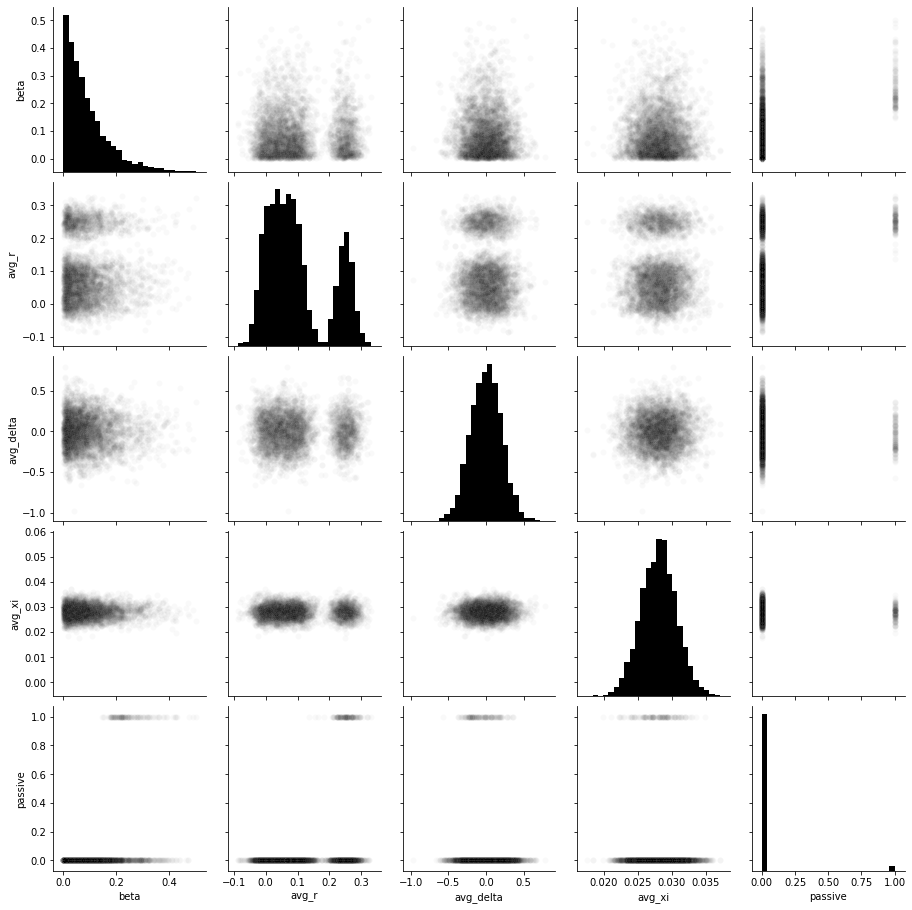

In [17]:
sns.pairplot(dg1, plot_kws={'alpha': 0.025, 'color': 'k'}, diag_kws={'bins': 25, 'color': 'k'})

In [18]:
df = dg1.copy()

In [19]:
df['effective_R'] = df.apply(lambda x: x['avg_r'] * x['beta'] - x['avg_xi'], axis=1)

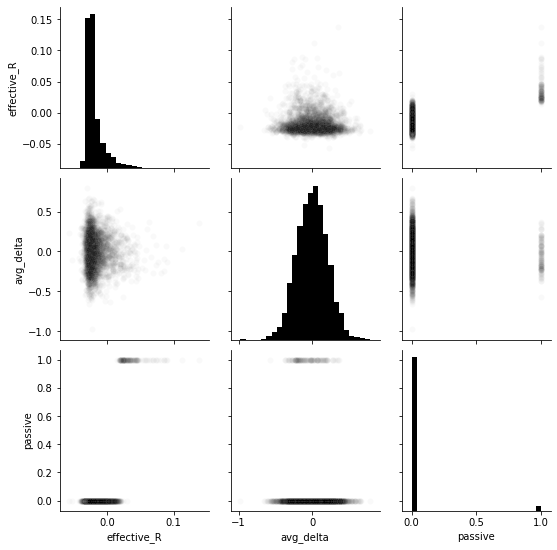

In [20]:
sns.pairplot(df[['effective_R', 'avg_delta', 'passive']], plot_kws={'alpha': 0.025, 'color': 'k'}, diag_kws={'bins': 25, 'color': 'k'})

## Historical data powered

In [21]:
# source: https://www.usinflationcalculator.com/inflation/historical-inflation-rates/
inflation = pd.read_csv('./inflation.csv').set_index('Year')
mu_xi = inflation.to_numpy().flatten().mean()
sigma_xi = inflation.to_numpy().flatten().std()

In [22]:
# source: https://www.macrotrends.net/2526/sp-500-historical-annual-returns
roi = pd.read_csv('./sp-500-historical-annual-returns.csv').set_index('date')
mu_r = roi.to_numpy().mean()
sigma_r = roi.to_numpy().std()

In [23]:
print(f"Inflation US: {mu_xi:0.2f} +/- {sigma_xi:0.2f} %")
print(f"S&P 500 ROI : {mu_r:0.2f} +/- {sigma_r:0.2f}%")

Inflation US: 3.24 +/- 4.98 %
S&P 500 ROI : 7.67 +/- 18.95%


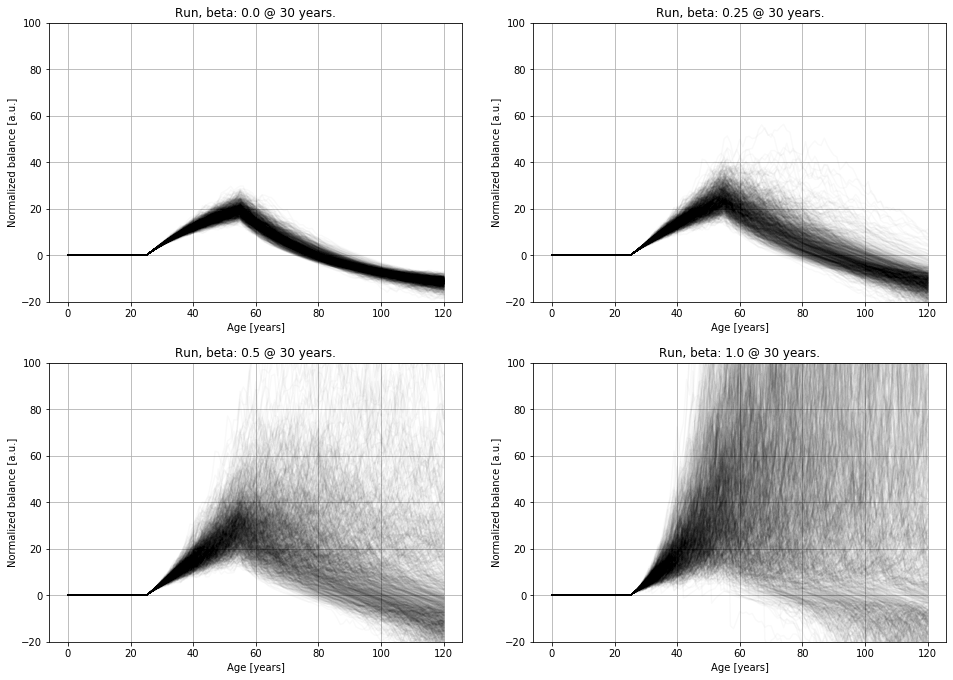

In [24]:
import warnings
warnings.simplefilter("ignore")

t = np.linspace(0, 120, num=121)
np.random.seed(42)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=4)

diags = []
for i, beta in enumerate((0.0, 0.25, 0.5, 1.0)):
    for _ in range(1000):
        you = RealLife()
        you.mu_r = 0.01 * mu_r
        you.sigma_r = 0.01 * sigma_r
        you.mu_xi = 0.01 * mu_xi
        you.sigma_xi = 0.01 * sigma_xi
        you.beta = beta
        you.balance_fn = lambda t: rect(t, you.x0, 30)
        df = simulate_with_random(you)

        diags.append({
            'beta': you.beta,
            'avg_r': you.get_average_r(),
            'avg_delta': you.get_average_delta(),
            'avg_xi': you.get_average_xi(),
            'passive': float(df[df.index > you.t0 + du].diff().sum()) > 0
        })
          
        axs[i // 2, i % 2].plot(t, sdeint(you.live, 0, t), alpha=0.025, color='black')
    axs[i // 2, i % 2].set_xlabel('Age [years]')
    axs[i // 2, i % 2].set_ylabel('Normalized balance [a.u.]')
    axs[i // 2, i % 2].set_title(f'Run, beta: {beta} @ 30 years.')
    axs[i // 2, i % 2].set_ylim((-20, 100))
    axs[i // 2, i % 2].grid()
plt.show()

In [25]:
df = pd.DataFrame(diags)
df.groupby('beta').mean()


,avg_r,avg_delta,avg_xi,passive
beta,,,,
0.00,0.076713,0.011865,0.032385,0.000
0.25,0.076496,0.002924,0.032159,0.000
0.50,0.077073,0.011195,0.032372,0.071
1.00,0.076795,-0.003248,0.032464,0.342


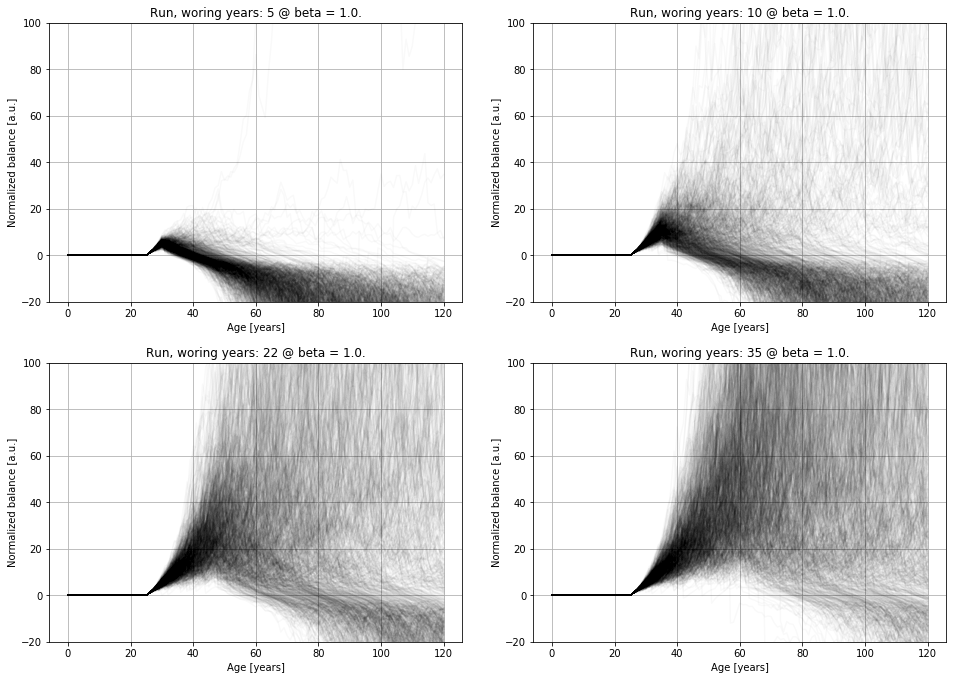

In [26]:
import warnings
warnings.simplefilter("ignore")

t = np.linspace(0, 120, num=121)
np.random.seed(42)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.tight_layout(pad=4)

diags = []
for i, wy in enumerate((5, 10, 22, 35)):
    for _ in range(1000):
        you = RealLife()
        you.mu_r = 0.01 * mu_r
        you.sigma_r = 0.01 * sigma_r
        you.mu_xi = 0.01 * mu_xi
        you.sigma_xi = 0.01 * sigma_xi
        you.beta = 1.0
        you.balance_fn = lambda t: rect(t, you.x0, wy)
        df = simulate_with_random(you)

        diags.append({
            'active': wy,
            'beta': you.beta,
            'avg_r': you.get_average_r(),
            'avg_delta': you.get_average_delta(),
            'avg_xi': you.get_average_xi(),
            'passive': int(float(df[df.index > you.t0 + du].diff().sum()) > 0),
        })

        axs[i // 2, i % 2].plot(t, sdeint(you.live, 0, t), alpha=0.025, color='black')
    axs[i // 2, i % 2].set_xlabel('Age [years]')
    axs[i // 2, i % 2].set_ylabel('Normalized balance [a.u.]')
    axs[i // 2, i % 2].set_title(f'Run, working years: {wy} @ beta = 1.0.')
    axs[i // 2, i % 2].set_ylim((-20, 100))
    axs[i // 2, i % 2].grid()
plt.show()

In [28]:
df = pd.DataFrame(diags)
df.groupby('active').mean()

,beta,avg_r,avg_delta,avg_xi,passive
active,,,,,
5,1.0,0.076713,0.011865,0.032385,0.097
10,1.0,0.076496,0.002924,0.032159,0.063
22,1.0,0.077073,0.011195,0.032372,0.239
35,1.0,0.076795,-0.003248,0.032464,0.380


## Parameter sweep

In [45]:
import warnings
warnings.simplefilter("ignore")

t = np.linspace(0, 120, num=121)
np.random.seed(42)

diags = []
for wy, beta in product(np.linspace(10, 40, num=31), np.linspace(0.0, 1.0, num=11)):
    for _ in range(1000):
        you = RealLife()
        you.mu_r = 0.01 * mu_r
        you.sigma_r = 0.01 * sigma_r
        you.mu_xi = 0.01 * mu_xi
        you.sigma_xi = 0.01 * sigma_xi
        you.beta = beta
        you.balance_fn = lambda t: rect(t, you.x0, wy)
        df = simulate_with_random(you)

        diags.append({
            'active': wy,
            'beta': you.beta,
            'avg_r': you.get_average_r(),
            'avg_delta': you.get_average_delta(),
            'avg_xi': you.get_average_xi(),
            'passive': int(float(df[df.index > you.t0 + du].diff().sum()) > 0),
        })

In [46]:
df = pd.DataFrame(diags)
df

,active,beta,avg_r,avg_delta,avg_xi,passive
0,10.0,0.0,0.086033,-0.359852,0.036015,0
1,10.0,0.0,0.050570,0.017791,0.035352,0
2,10.0,0.0,0.089836,0.051640,0.032479,0
3,10.0,0.0,0.107419,0.497018,0.036893,0
4,10.0,0.0,0.134450,-0.070712,0.026260,0
...,...,...,...,...,...,...
340995,40.0,1.0,0.103212,-0.204782,0.032991,1
340996,40.0,1.0,0.091526,0.051019,0.037561,1
340997,40.0,1.0,0.089630,-0.174714,0.039534,0
340998,40.0,1.0,0.084146,0.403882,0.029409,0


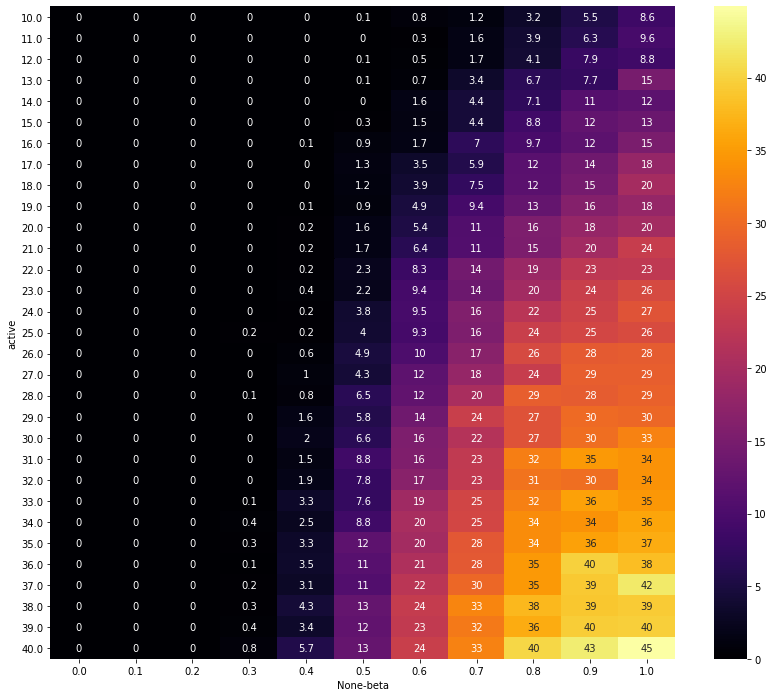

In [67]:
agg = df[['active', 'beta', 'passive']].groupby(by=['active', 'beta']).mean().unstack() * 100
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(agg, 
    xticklabels=np.round(np.linspace(0.0, 1.0, num=11), 2),
    cmap='inferno',
    annot=True,
    lw=0)

In [69]:
df.to_csv('./monte-carlo.csv', index=False)